# Toxic comments classifier

**Problem**: Varying-length textual comments, containing typos, slang, rare words, etc.<br>
**Outcome**: Multi-label classification of 6 types of "toxicity" of comments. Labels slightly correlated, very sparse and imbalanced.
<br>
<br>
This notebook shows how to apply RNN for this classification task, using Bidirectional LSTM and hybrid lstm+conv1D architectures. Several losses are explored (BCE and focal loss). Glove pre-trained embeddings are used in some of the models.
<br>
<br>
**Model eval on val data (Macro F1)**:<br>
- M1: LSTM + fixed class weights (embedding64 + 2 bidirectional layers): **0.43**
- M2: M1 + undersampling 0s + oversampling small cats + embedding128: **0.47**
- M3: LSTM + focal loss (embedding256, lower dropouts + 2 bidirectional layers): **0.35**
- M4: M1 + pre-trained Glove embeddings (200d), back to BCE loss: **0.47**
- M5: Hybrid LSTM+Conv + Glove embeddings (200d + Conv1D*128 + 2 bidirectional: ****

**TO-DOs**:<br>
Plenty of things to improve:<br>
- Larger pre-trained embeddings (currently used 200d only)
- Larger variety of architectures+pre-trained embeddings ensembling
- Did not adequately address class imbalance - class weights/sampling don't work, but different loss functions might
- Train on the entire dataset
- Translation augmentation 


# 0. Data/library imports

In [0]:
# Install TF2.0 gpu, helper lib and pretrained glove embeddings
# !pip uninstall tensorflow
# !pip install tensorflow-gpu
# !pip install DLHelper
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [0]:
# Imports
import tensorflow as tf
from tensorflow import keras
from DLHelper.imports import *

In [3]:
# Download kaggle data
keys = eval(open('kaggle.json', 'r').read())

import os
os.environ['KAGGLE_USERNAME'] = keys["username"]  
os.environ['KAGGLE_KEY'] = keys["key"]
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 46.9MB/s]
 38% 9.00M/23.4M [00:00<00:00, 21.5MB/s]
100% 23.4M/23.4M [00:00<00:00, 47.7MB/s]
 34% 9.00M/26.3M [00:00<00:00, 20.3MB/s]
100% 26.3M/26.3M [00:00<00:00, 44.6MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 97.5MB/s]


In [0]:
# Make data dir
DATA_DIR = Path('data/toxic')
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
# # Unzip data to data dir
# !unzip train.csv.zip -d {DATA_DIR}/'train'
# !unzip glove.6B.zip -d {DATA_DIR}

Archive:  train.csv.zip
  inflating: data/toxic/train/train.csv  
Archive:  glove.6B.zip
  inflating: data/toxic/glove.6B.50d.txt  
  inflating: data/toxic/glove.6B.100d.txt  
  inflating: data/toxic/glove.6B.200d.txt  
  inflating: data/toxic/glove.6B.300d.txt  


In [0]:
# Read data
data_df = pd.read_csv(DATA_DIR/'train/train.csv')

# 1. Exploratory data analysis
* 6 label classes, two types of imbalance: 1) there are generally way more 0's 
than 1's, largest outcome category accounts for 10% of all examples; 2) outcome classes are imbalanced among themselves (largest/smallest categories differ >10x)<br>
* Most examples have 0 labels (~90%). If we use pre-trained embeddings, we might be able to undersample these comments a lot. Virtually no examples with 5-6 labels.
* The smallest class ("threats") correlated with all other classes, hence it will not be easy to oversample it<br>
* Comments vary in length a lot, from 6 to 5,000 chars (most around 100-300)

In [7]:
data_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
# Normalized label frequencies
data_df.iloc[:, 2:].apply(np.mean, axis=0)

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

In [9]:
# Comment textual length distribution
data_df["comment_text"].map(lambda x: len(x)).describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

In [10]:
# Number of 1-labels per example
data_df.iloc[:, 2:].apply(np.sum, axis=1).value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

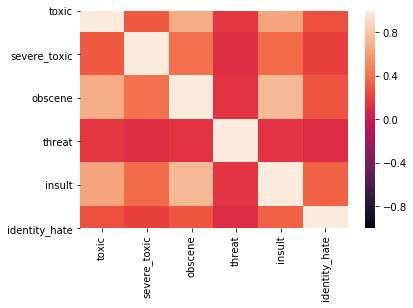

In [12]:
# Label correlations
heatmap_inp = data_df.iloc[(data_df.iloc[:, 2:].apply(np.sum, axis=1) > 0).index.values, 2:].corr()
sns.heatmap(heatmap_inp, vmin=-1, vmax=1)

In [13]:
# Nastiest comments
data_df[(data_df.iloc[:, 2:].apply(np.sum, axis=1) == 6)].iloc[:5, 1]

1017     WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...
1312     SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!
7299     You're a stupid cunt \n\nFuck you dumb arse, y...
13648    Bitch \n\nYou are a little bitch. I fuckin spe...
13964    I am going to murder ZimZalaBim ST47 for being...
Name: comment_text, dtype: object

# 2. Train/val/test split + pipeline

For time-saving reasons, 20% of train and validation data will be used in further analyses. NOTE: for over/undersampling, we will use 100% of the data.

In [0]:
# Train test split
data_df = data_df.sample(frac=1, replace=False)
train_df = data_df[:np.ceil(data_df.shape[0] * 0.8).astype(np.int)]
val_df = data_df[np.ceil(data_df.shape[0] * 0.8).astype(np.int):np.ceil(data_df.shape[0] * 0.9).astype(np.int)].reset_index(drop=True)
test_df = data_df[np.ceil(data_df.shape[0] * 0.9).astype(np.int):].reset_index(drop=True)

In [16]:
print(train_df.shape, val_df.shape, test_df.shape)

(127657, 8) (15957, 8) (15957, 8)


In [0]:
# Let's work with 20% of the data
train_df_small = train_df.sample(frac=0.2)
val_df_small = val_df.sample(frac=0.2)
test_df_small = test_df.sample(frac=0.2)

In [198]:
train_df_small.iloc[:,2:].apply(np.mean)

toxic            0.094865
severe_toxic     0.010066
obscene          0.051153
threat           0.002624
insult           0.048529
identity_hate    0.009204
dtype: float64

In [200]:
val_df_small.iloc[:,2:].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000
mean,0.106550,0.012222,0.060796,0.005014,0.057976,0.010655
std,0.308588,0.109892,0.238993,0.070644,0.233734,0.102688
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
# Dataframes to datasets
def df_to_ds(df):
    label_df = df.iloc[:, 2:]
    label_ds = tf.data.Dataset.from_tensor_slices(label_df.values)
    text_df = df['comment_text']
    text_ds = tf.data.Dataset.from_tensor_slices(text_df.values)
    out_ds = tf.data.Dataset.zip((text_ds, label_ds))
    return out_ds

In [0]:
(train_ds, val_ds, test_ds) = (df_to_ds(train_df_small), df_to_ds(val_df_small), df_to_ds(test_df_small))

In [20]:
for x,y in train_ds.take(16):
    print(x)
    print(y)

tf.Tensor(b"The list is certainly not all-inclusinve and is not intended to be that.  Since your father uses the term, it's likely that others did as well. Often these things are started in or perpetuated by novels and comic books.  At any rate, if you could establish that it is a noteworthy nickname, then it'd probably be appropriate to add.", shape=(), dtype=string)
tf.Tensor([0 0 0 0 0 0], shape=(6,), dtype=int64)
tf.Tensor(b"Yarrr! \n\nHeil Hitler, matey!\n\nYou're invited to comment on the FAC of the article on Kronan.\n\nAnd that goes for anyone else skulking around this talkpage. Go on. Do your worst!\n\n A little gift  \n\nI stopped by just to say Thank You!  D   talk", shape=(), dtype=string)
tf.Tensor([1 0 0 0 0 0], shape=(6,), dtype=int64)
tf.Tensor(b'"==Please stop vandalizing the Halo 3 article==\n\nYou have continually vandalized the Halo 3 page with this ""plot"" nonsnese, and then replied to it\'s deletion with a string of hate words and censor bypasses. Please stop.\n\

## Preprocessing

Clean out non-alphabetic chars, lowercase, pad beginning of the comment to X length.

In [0]:
# Preprocessing pipeline
def preprocess(x, y, max_length=200):
    x = tf.strings.regex_replace(x, rb"<br\s*/?>", b" ")
    x = tf.strings.regex_replace(x, b"[^a-zA-Z']", b" ")
    x = tf.strings.regex_replace(x, b"([a-zA-Z]+)(')", r"\1")
    x = tf.strings.lower(x)
    x = tf.strings.split(x)
    x = x.to_tensor(default_value="0")
    paddings = tf.constant([[0, 0], [max_length, 0]])
    x = tf.pad(x,  paddings, constant_values=b"<pad>")
    x = tf.RaggedTensor.from_tensor(x, padding="0")
    x = x[:, -max_length:]
    x = x.to_tensor()
    return x, y

In [22]:
for x,y in train_ds.batch(16).take(1).map(preprocess):
    print(x, x.shape)

tf.Tensor(
[[b'<pad>' b'<pad>' b'<pad>' ... b'appropriate' b'to' b'add']
 [b'<pad>' b'<pad>' b'<pad>' ... b'you' b'd' b'talk']
 [b'<pad>' b'<pad>' b'<pad>' ... b'bypasses' b'please' b'stop']
 ...
 [b'<pad>' b'<pad>' b'<pad>' ... b'excellent' b'reliable' b'sources']
 [b'<pad>' b'<pad>' b'<pad>' ... b'ethiopians' b'religious' b'beliefs']
 [b'<pad>' b'<pad>' b'<pad>' ... b'started' b'coming' b'out']], shape=(16, 200), dtype=string) (16, 200)


In [0]:
# Tokenizer
def make_vocabulary(dataset):
    vocabulary = Counter()
    for x, _ in dataset.batch(1).map(preprocess):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

In [0]:
# Vocab size
VOCABULARY_SIZE = 10000
vocabulary = make_vocabulary(train_ds)

In [25]:
vocabulary.most_common(20)

[(b'<pad>', 3671492),
 (b'the', 65757),
 (b'to', 40769),
 (b'and', 29575),
 (b'of', 29174),
 (b'a', 28945),
 (b'you', 27818),
 (b'i', 27785),
 (b'is', 23495),
 (b'that', 20745),
 (b'in', 19015),
 (b'it', 18357),
 (b'for', 14025),
 (b'this', 13594),
 (b'not', 12818),
 (b'on', 12224),
 (b'be', 11891),
 (b'as', 10441),
 (b'have', 9935),
 (b'are', 9640)]

In [0]:
# Truncated vocabulary (to 10k words)
vocab_trunc = tf.constant([i[0] for i in vocabulary.most_common(VOCABULARY_SIZE)])
vocab_trunc_ids = tf.range(tf.shape(vocab_trunc)[0], dtype=tf.int64)

In [27]:
# Out of vocabulary buckets
n_oov_buckets = VOCABULARY_SIZE // 20
vocab_init = tf.lookup.KeyValueTensorInitializer(vocab_trunc, vocab_trunc_ids)
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)
table.lookup(tf.constant([b"this is damn a hateful shit comment".split()]))

<tf.Tensor: id=153851, shape=(1, 7), dtype=int64, numpy=array([[  13,    8, 1728,    5, 7616,  433,  187]])>

In [0]:
# Encode words
def encode_words(x, y):
    return table.lookup(x), y

## Train/val dataset creation

In [0]:
# Train BS16
train_dataset = (
    train_ds.batch(16)
    .map(preprocess)
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

In [30]:
# Check contents
for x ,y in train_dataset.take(1):
    print(x[0])

tf.Tensor(
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     1   146     8   563
    14    45 10192     3     8    14  1360     2    16     9   158    20
  1482   877     1   387    51   627    

In [0]:
# Validation BS16
val_dataset = (
    val_ds.batch(16)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
# Steps
train_steps = len(train_df_small) // 16
val_steps = len(val_df_small) // 16

# 3. Models

Models used:<br>
- M1: LSTM + fixed class weights (embedding64 + 2 bidirectional layers)
- M2: M1 + undersampling 0s + oversampling small cats + embedding128
- M3: LSTM + focal loss (embedding256, lower dropouts + 2 bidirectional layers)
- M4: M1 + pre-trained Glove embeddings (200d), back to BCE loss
- M5: Hybrid LSTM+Conv + Glove embeddings (200d + Conv1D*128 + 2 bidirectional)

## M1: LSTM + fixed class weights 
64 Embeddings + 2 bi-directional LSTM layers 

### Create M1

In [0]:
# Define model creator
def LSTMlearner(
    n_categories, embedding_size, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.sigmoid),
        ]
    )

In [0]:
# Create and compile
model_1 = LSTMlearner(
    n_categories=6,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.2,
    dropout=0.5,
)

model_1.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

### Train M1

In [189]:
# Train
history = model_1.fit(
    train_dataset,
    steps_per_epoch=train_steps // 6,
    validation_data=val_dataset,
    validation_steps=val_steps // 6,
    epochs=6,
    class_weight={0: 1., 1: 10.},
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 265 steps, validate for 33 steps
Epoch 1/6
265/265 [==============================] - 146s 551ms/step - loss: 0.1697 - binary_accuracy: 0.9625 - val_loss: 0.1450 - val_binary_accuracy: 0.9637
Epoch 2/6
265/265 [==============================] - 138s 523ms/step - loss: 0.1394 - binary_accuracy: 0.9664 - val_loss: 0.1373 - val_binary_accuracy: 0.9637
Epoch 3/6
265/265 [==============================] - 139s 524ms/step - loss: 0.1265 - binary_accuracy: 0.9664 - val_loss: 0.1180 - val_binary_accuracy: 0.9637
Epoch 4/6
265/265 [==============================] - 138s 520ms/step - loss: 0.1090 - binary_accuracy: 0.9663 - val_loss: 0.1067 - val_binary_accuracy: 0.9678
Epoch 5/6
265/265 [==============================] - 138s 522ms/step - loss: 0.0905 - binary_accuracy: 0.9700 - val_loss: 0.0785 - val_binary_accuracy: 0.9751
Epoch 6/6
265/265 [==============================] - 139s 523ms/step - loss: 0.0771 - binary_accuracy: 0.9743 - val_loss: 0.0692 - val_binary_accuracy: 0.9760


### Predict M1

In [0]:
preds = model_1.predict_generator(val_dataset, steps=val_steps)

In [207]:
print(
    "Label distribution in validation set:\n\n",
    val_df_small.iloc[:,2:].apply(np.mean),
    "\n\nClassification report of M1:\n\n",
    sk.metrics.classification_report(val_df_small.iloc[:len(preds), 2:], np.round(preds))
)

Label distribution in validation set:

 toxic            0.106550
severe_toxic     0.012222
obscene          0.060796
threat           0.005014
insult           0.057976
identity_hate    0.010655
dtype: float64 

Classification report of M1:

               precision    recall  f1-score   support

           0       0.67      0.73      0.70       310
           1       0.62      0.41      0.49        58
           2       0.64      0.74      0.69       169
           3       0.00      0.00      0.00         0
           4       0.66      0.73      0.69       167
           5       0.00      0.00      0.00         0

   micro avg       0.62      0.71      0.66       704
   macro avg       0.43      0.44      0.43       704
weighted avg       0.66      0.71      0.68       704
 samples avg       0.06      0.06      0.06       704



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


## M2: undersample all-0s + oversample small categories 

Let's also reduce dropout and class weights, as the model is having a hard time learning, not even close to overfitting.


In [349]:
# Check how many all-0-label cases we have
print(f"Total length of full train dataset: {train_df.shape[0]}")
train_df_small_no_0 = train_df[train_df.iloc[:,2:].apply(np.mean, axis=1) > 0]
print(f"Total length if all-0-label examples are removed: {train_df_small_no_0.shape[0]}")

Total length of full train dataset: 127657
Total length if all-0-label examples are removed: 13009


In [0]:
# Create sampling weights for the smallest label categories 
weights = (
    train_df["severe_toxic"] * 4 + \
    train_df["threat"] * 4 + \
    train_df["identity_hate"] * 4 \
    )

# Sample 20% of the entire train dataframe with these weights
train_append = train_df.sample(frac=0.2, weights=weights)

In [350]:
# Compare label distributions (top - new, bottom - old)
print(
    train_append.iloc[:, 2:].describe().loc["mean"],
    train_df.iloc[:, 2:].describe().loc["mean"]
)

toxic            0.135247
severe_toxic     0.035565
obscene          0.087188
threat           0.010928
insult           0.083624
identity_hate    0.029807
Name: mean, dtype: float64 toxic            0.095913
severe_toxic     0.009862
obscene          0.052813
threat           0.002969
insult           0.049233
identity_hate    0.008703
Name: mean, dtype: float64


In [0]:
# Append and shuffle train dataset
train_df_small_no_0 = train_df_small_no_0.append(train_append, ignore_index=True)
train_ds_undersampled = df_to_ds(train_df_small_no_0.sample(frac=1))

train_dataset = (
    train_ds_undersampled.batch(16)
    .map(preprocess)
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

train_steps = train_df_small_no_0.shape[0] // 16

## Create M2

In [0]:
model_2 = LSTMlearner(
    n_categories=6,
    embedding_size=128,
    lstm_size=64,
    lstm_dropout=0.2,
    dropout=0.3,
)

model_2.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=5e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

## Train M2

In [354]:
history = model_2.fit(
    train_dataset,
    steps_per_epoch=train_steps // 6,
    validation_data=val_dataset,
    validation_steps=val_steps // 6,
    epochs=6,
    class_weight={0: 1., 1: 2.5},
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 401 steps, validate for 33 steps
Epoch 1/6
401/401 [==============================] - 251s 626ms/step - loss: 0.3349 - binary_accuracy: 0.8664 - val_loss: 0.1000 - val_binary_accuracy: 0.9722
Epoch 2/6
401/401 [==============================] - 233s 581ms/step - loss: 0.2093 - binary_accuracy: 0.9174 - val_loss: 0.0695 - val_binary_accuracy: 0.9789
Epoch 3/6
401/401 [==============================] - 232s 579ms/step - loss: 0.1942 - binary_accuracy: 0.9241 - val_loss: 0.0666 - val_binary_accuracy: 0.9779
Epoch 4/6
401/401 [==============================] - 232s 579ms/step - loss: 0.1885 - binary_accuracy: 0.9257 - val_loss: 0.0669 - val_binary_accuracy: 0.9811
Epoch 5/6
401/401 [==============================] - 231s 576ms/step - loss: 0.1757 - binary_accuracy: 0.9313 - val_loss: 0.0616 - val_binary_accuracy: 0.9807
Epoch 6/6
401/401 [==============================] - 231s 576ms/step - loss: 0.1732 - binary_accuracy: 0.9306 - val_loss: 0.0561 - val_binary_accuracy: 0.9833


## Predict M2

In [356]:
preds = model_2.predict_generator(val_dataset, steps=val_steps)
print(
    "\n\nClassification report of M1:\n\n",
    sk.metrics.classification_report(val_df_small.iloc[:len(preds), 2:], np.round(preds))
)



Classification report of M1:

               precision    recall  f1-score   support

           0       0.70      0.86      0.77       339
           1       0.68      0.44      0.53        39
           2       0.79      0.80      0.79       194
           3       0.00      0.00      0.00        16
           4       0.77      0.73      0.75       185
           5       0.00      0.00      0.00        34

   micro avg       0.74      0.74      0.74       807
   macro avg       0.49      0.47      0.47       807
weighted avg       0.69      0.74      0.71       807
 samples avg       0.08      0.08      0.08       807



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


# M3: Focal loss, embedding256, lower dropouts

Focal loss was originally created for object detection in images problems, where you have a lot of empty background pixels and very few pixels that contain the actual object (i.e. class imbalance). The loss puts more emphasis on "difficult" or misclassified examples and downscales easy examples, intensity of which is regulated with gamma and alpha parameters.<br><br>More info: [Original paper](https://arxiv.org/abs/1708.02002), [Medium summary](https://towardsdatascience.com/review-retinanet-focal-loss-object-detection-38fba6afabe4)

In [0]:
# Original implementation by (slightly adjusted here) and props for Umberto Griffo 
# Source: https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py
import keras.backend as K

k_eps = K.epsilon()

def binary_focal_loss(gamma=2., alpha=.25):
    def binary_focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        epsilon = k_eps
        # clip to prevent NaN's and Inf's
        pt_1 = tf.clip_by_value(pt_1, epsilon, 1. - epsilon)
        pt_0 = tf.clip_by_value(pt_0, epsilon, 1. - epsilon)
        return -tf.reduce_sum(alpha * tf.math.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -tf.reduce_sum((1 - alpha) * tf.math.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return binary_focal_loss_fixed

### Create M3

In [0]:
model_3 = LSTMlearner(
    n_categories=6,
    embedding_size=256,
    lstm_size=64,
    lstm_dropout=0.15,
    dropout=0.3,
)

model_3.compile(
    loss=binary_focal_loss(),
    optimizer=keras.optimizers.Adam(lr=5e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

### Train M3

In [393]:
history = model_3.fit(
    train_dataset,
    steps_per_epoch=train_steps // 6,
    validation_data=val_dataset,
    validation_steps=val_steps // 6,
    epochs=6,
    # class_weight={0: 1., 1: 2.5},
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 401 steps, validate for 33 steps
Epoch 1/6
401/401 [==============================] - 301s 749ms/step - loss: 3.4138 - binary_accuracy: 0.8620 - val_loss: 0.9128 - val_binary_accuracy: 0.9729
Epoch 2/6
401/401 [==============================] - 275s 686ms/step - loss: 2.0088 - binary_accuracy: 0.9123 - val_loss: 0.6590 - val_binary_accuracy: 0.9779
Epoch 3/6
401/401 [==============================] - 274s 682ms/step - loss: 1.9066 - binary_accuracy: 0.9143 - val_loss: 0.5899 - val_binary_accuracy: 0.9814
Epoch 4/6
401/401 [==============================] - 275s 687ms/step - loss: 1.8589 - binary_accuracy: 0.9155 - val_loss: 0.5798 - val_binary_accuracy: 0.9817
Epoch 5/6
401/401 [==============================] - 277s 691ms/step - loss: 1.7154 - binary_accuracy: 0.9221 - val_loss: 0.6003 - val_binary_accuracy: 0.9830
Epoch 6/6
401/401 [==============================] - 276s 687ms/step - loss: 1.6603 - binary_accuracy: 0.9223 - val_loss: 0.5301 - val_binary_accuracy: 0.9839


### Predict M3

In [394]:
preds = model_3.predict_generator(val_dataset, steps=val_steps)
print(
    "\n\nClassification report of M1:\n\n",
    sk.metrics.classification_report(val_df_small.iloc[:len(preds), 2:], np.round(preds))
)



Classification report of M1:

               precision    recall  f1-score   support

           0       0.85      0.78      0.81       339
           1       0.00      0.00      0.00        39
           2       0.91      0.62      0.74       194
           3       0.00      0.00      0.00        16
           4       0.91      0.39      0.55       185
           5       0.00      0.00      0.00        34

   micro avg       0.88      0.57      0.69       807
   macro avg       0.45      0.30      0.35       807
weighted avg       0.79      0.57      0.65       807
 samples avg       0.08      0.06      0.07       807



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


## M4: Pre-trained Glove embeddings

200-dimensional embeddings version of Glove is used. The embedding layer is first trained frozen, then some more epochs with the layer unfrozen and longer comments (200 words -> 300).

In [0]:
# Read embeddings into a dict
embeddings_index = {}
with open(os.path.join(DATA_DIR, 'glove.6B.200d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

# Create embedding array based on our vocab
embedding_matrix = np.zeros((VOCABULARY_SIZE + n_oov_buckets, 200))
for word, i in zip(vocab_trunc, vocab_trunc_ids):
    embedding_vector = embeddings_index.get(word.numpy())
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i.numpy()] = embedding_vector

# Pre-create embedding layer
embedding_layer = keras.layers.Embedding(VOCABULARY_SIZE + n_oov_buckets,
                                        200,
                                        mask_zero=True,
                                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                        trainable=False,
                                        input_shape=[None])

### Create M4

In [0]:
def LSTM_transfer_learner(
    n_categories, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            embedding_layer,
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.sigmoid),
        ]
    )

In [0]:
model_4 = LSTM_transfer_learner(
    n_categories=6,
    lstm_size=64,
    lstm_dropout=0.15,
    dropout=0.3,
)

model_4.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=5e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

In [441]:
model_4.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 200)         2100000   
_________________________________________________________________
bidirectional_46 (Bidirectio (None, None, 128)         135680    
_________________________________________________________________
bidirectional_47 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
global_max_pooling1d_23 (Glo (None, 128)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 774       
Total params: 2,335,270
Trainable params: 2,335,270
Non-trainable params: 0
___________________________________________

### Train M4 (frozen)

In [442]:
history = model_4.fit(
    train_dataset,
    steps_per_epoch=train_steps // 6,
    validation_data=val_dataset,
    validation_steps=val_steps // 6,
    epochs=6,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 401 steps, validate for 33 steps
Epoch 1/6
401/401 [==============================] - 288s 718ms/step - loss: 0.3138 - binary_accuracy: 0.8784 - val_loss: 0.0859 - val_binary_accuracy: 0.9732
Epoch 2/6
401/401 [==============================] - 254s 633ms/step - loss: 0.1949 - binary_accuracy: 0.9241 - val_loss: 0.0654 - val_binary_accuracy: 0.9785
Epoch 3/6
401/401 [==============================] - 255s 636ms/step - loss: 0.1909 - binary_accuracy: 0.9252 - val_loss: 0.0598 - val_binary_accuracy: 0.9814
Epoch 4/6
401/401 [==============================] - 255s 636ms/step - loss: 0.1882 - binary_accuracy: 0.9258 - val_loss: 0.0616 - val_binary_accuracy: 0.9814
Epoch 5/6
401/401 [==============================] - 263s 655ms/step - loss: 0.1722 - binary_accuracy: 0.9312 - val_loss: 0.0584 - val_binary_accuracy: 0.9823
Epoch 6/6
401/401 [==============================] - 253s 630ms/step - loss: 0.1694 - binary_accuracy: 0.9318 - val_loss: 0.0574 - val_binary_accuracy: 0.9823


In [443]:
model_4._layers[:3]

### Train M4 (unfrozen + longer comments)

In [444]:
model_4._layers[1].trainable = True
model_4._layers[1].trainable 

True

In [0]:
train_dataset = (
    train_ds_undersampled.batch(16)
    .map(partial(preprocess, max_length=300))
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

In [446]:
history = model_4.fit(
    train_dataset,
    steps_per_epoch=train_steps // 6,
    validation_data=val_dataset,
    validation_steps=val_steps // 6,
    epochs=6,
    class_weight={'0': 1., '1': 2.5},
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 401 steps, validate for 33 steps
Epoch 1/6
401/401 [==============================] - 375s 936ms/step - loss: 0.1641 - binary_accuracy: 0.9338 - val_loss: 0.0535 - val_binary_accuracy: 0.9814
Epoch 2/6
401/401 [==============================] - 376s 937ms/step - loss: 0.1517 - binary_accuracy: 0.9392 - val_loss: 0.0527 - val_binary_accuracy: 0.9820
Epoch 3/6
401/401 [==============================] - 375s 935ms/step - loss: 0.1583 - binary_accuracy: 0.9366 - val_loss: 0.0538 - val_binary_accuracy: 0.9820
Epoch 4/6
401/401 [==============================] - 385s 960ms/step - loss: 0.1580 - binary_accuracy: 0.9372 - val_loss: 0.0569 - val_binary_accuracy: 0.9807
Epoch 5/6
144/401 [=========>....................] - ETA: 3:55 - loss: 0.1635 - binary_accuracy: 0.9347WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,binary_accuracy,lr


KeyboardInterrupt: ignored

### Predict M4

In [447]:
val_dataset = (
    val_ds.batch(16)
    .map(partial(preprocess, max_length=300))
    .map(encode_words)
)

preds = model_4.predict_generator(val_dataset, steps=val_steps)
print(
    "\n\nClassification report of M1:\n\n",
    sk.metrics.classification_report(val_df_small.iloc[:len(preds), 2:], np.round(preds))
)



Classification report of M1:

               precision    recall  f1-score   support

           0       0.61      0.90      0.73       339
           1       0.72      0.46      0.56        39
           2       0.80      0.80      0.80       194
           3       0.00      0.00      0.00        16
           4       0.78      0.72      0.75       185
           5       0.00      0.00      0.00        34

   micro avg       0.69      0.76      0.72       807
   macro avg       0.49      0.48      0.47       807
weighted avg       0.66      0.76      0.70       807
 samples avg       0.09      0.08      0.08       807



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


## M5: Hybrid Conv1D+LSTM model with Glove embeddings

Last model, extra conv layer in front -> train with embeddings frozen -> unfreeze and train more

### Create M5

In [0]:
def Hybrid_transfer_learner(
    n_categories, conv_size, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            # Embedding
            keras.layers.Embedding(VOCABULARY_SIZE + n_oov_buckets,
                200,
                mask_zero=True,
                embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                trainable=False,
                input_shape=[None]),
            # Conv layer
            keras.layers.Conv1D(
                filters=conv_size,
                kernel_size=4,
                padding="same",
                activation=keras.activations.relu,
                kernel_initializer=keras.initializers.he_uniform(),
            ),
            # Dropout 1
            keras.layers.Dropout(dropout),
            # LSTM 1
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            # LSTM 2
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            # Dropout 2
            keras.layers.Dropout(dropout),
            # Output
            keras.layers.Dense(n_categories, activation=keras.activations.sigmoid),
        ]
    )

In [0]:
model_5 = Hybrid_transfer_learner(
    n_categories=6,
    conv_size=128,
    lstm_size=64,
    lstm_dropout=0.15,
    dropout=0.3,
)

model_5.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=5e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

### Train M5 (frozen)

In [457]:
history = model_5.fit(
    train_dataset,
    steps_per_epoch=train_steps // 6,
    validation_data=val_dataset,
    validation_steps=val_steps // 6,
    epochs=6,
    class_weight={'0': 1., '1': 2.5},
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 401 steps, validate for 33 steps
Epoch 1/6
401/401 [==============================] - 330s 824ms/step - loss: 0.4012 - binary_accuracy: 0.8303 - val_loss: 0.2323 - val_binary_accuracy: 0.9637
Epoch 2/6
401/401 [==============================] - 321s 800ms/step - loss: 0.3758 - binary_accuracy: 0.8381 - val_loss: 0.2117 - val_binary_accuracy: 0.9637
Epoch 3/6
401/401 [==============================] - 319s 796ms/step - loss: 0.3805 - binary_accuracy: 0.8329 - val_loss: 0.2425 - val_binary_accuracy: 0.9637
Epoch 4/6
401/401 [==============================] - 319s 796ms/step - loss: 0.3806 - binary_accuracy: 0.8336 - val_loss: 0.2433 - val_binary_accuracy: 0.9637
Epoch 5/6
401/401 [==============================] - 320s 799ms/step - loss: 0.3696 - binary_accuracy: 0.8399 - val_loss: 0.2355 - val_binary_accuracy: 0.9637


### Train M5 (unfrozen, no sampling)

In [461]:
model_5._layers[1].trainable = True

train_dataset = (
    train_ds.batch(16)
    .map(partial(preprocess, max_length=300))
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

train_steps = train_df_small.shape[0] // 16

history = model_5.fit(
    train_dataset,
    steps_per_epoch=train_steps // 6,
    validation_data=val_dataset,
    validation_steps=val_steps // 6,
    epochs=3,
    class_weight={'0': 1., '1': 2.5},
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 265 steps, validate for 33 steps
Epoch 1/3
265/265 [==============================] - 242s 915ms/step - loss: 0.2262 - binary_accuracy: 0.9592 - val_loss: 0.2270 - val_binary_accuracy: 0.9637
Epoch 2/3
265/265 [==============================] - 224s 845ms/step - loss: 0.2177 - binary_accuracy: 0.9648 - val_loss: 0.2222 - val_binary_accuracy: 0.9637
Epoch 3/3
265/265 [==============================] - 215s 812ms/step - loss: 0.2129 - binary_accuracy: 0.9651 - val_loss: 0.2179 - val_binary_accuracy: 0.9637


# 4. Summary

Evaluations on val dataset (Macro F1):<br>
- M1: 0.43
- M2: 0.47
- M3: 0.35
- M4: 0.47
- M5: 